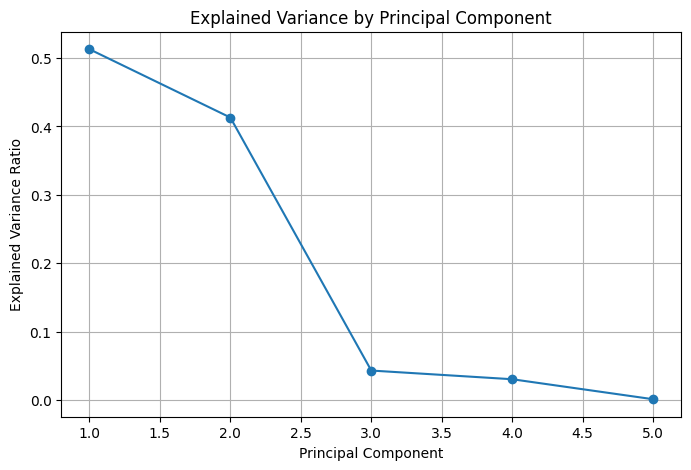

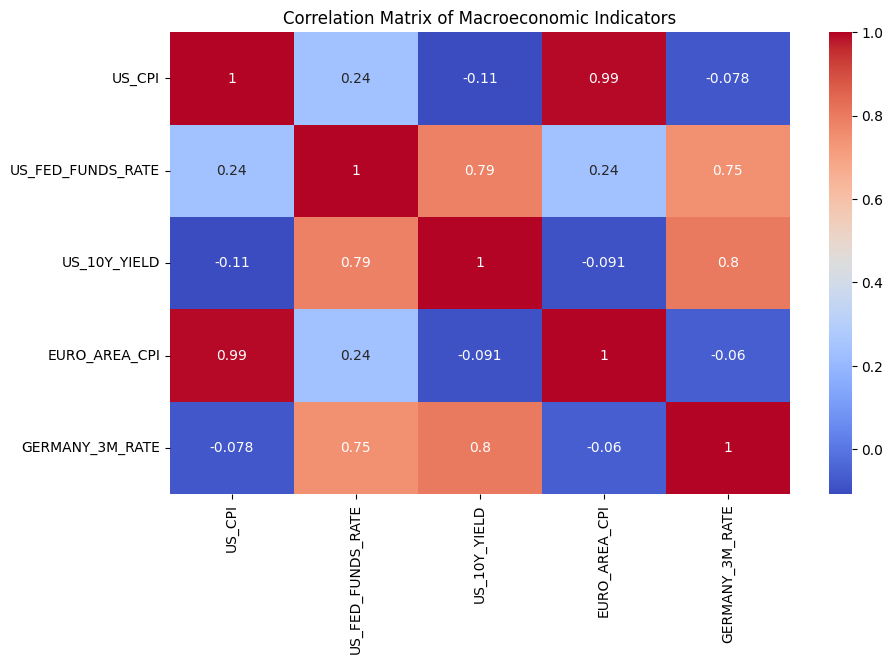

<Axes: title={'center': 'Principal Component 1 (Macro Trend)'}, xlabel='Date'>

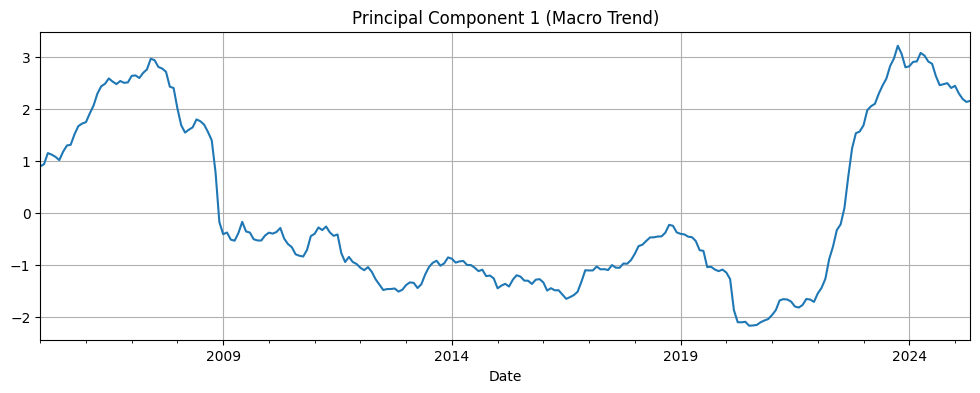

In [95]:
# notebooks/pca_macro_analysis.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load macroeconomic data
macro_df = pd.read_csv("../data/macro_data.csv", parse_dates=["Date"], index_col="Date")
macro_df.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(macro_df)

# Run PCA
pca = PCA(n_components=min(len(macro_df.columns), 5))
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, index=macro_df.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# Correlation heatmap of original macro indicators
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(X_scaled, columns=macro_df.columns).corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Matrix of Macroeconomic Indicators")
plt.show()

# Visualize PC1 over time
pca_df['PC1'].plot(figsize=(12, 4), title="Principal Component 1 (Macro Trend)", grid=True)


<Axes: title={'center': 'Macro Divergence from Global Trend (PC1)'}, xlabel='Date'>

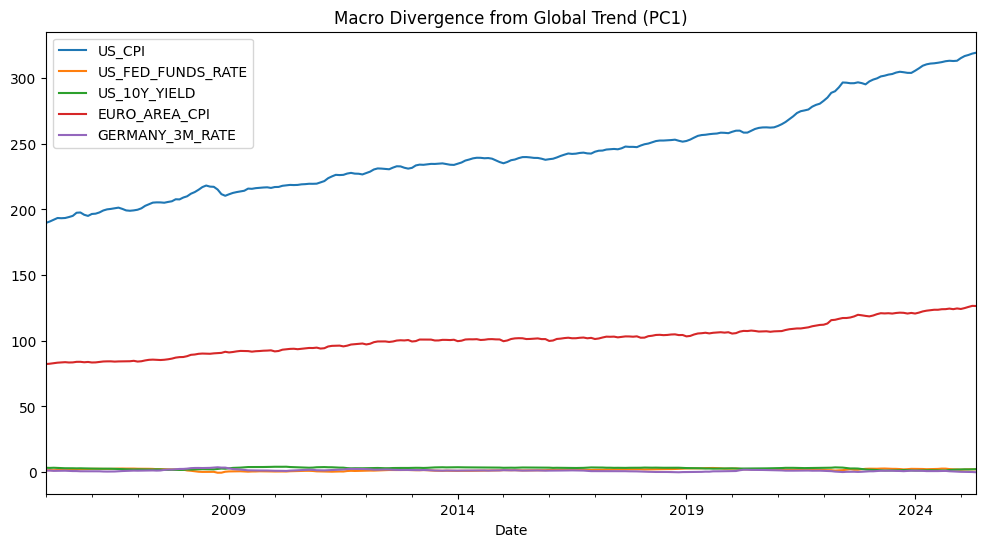

In [96]:
# Calculate divergence: actual macro value - global macro trend (PC1)
divergence_df = macro_df.sub(pca_df['PC1'], axis=0)

# Plot divergence for each country/indicator

divergence_df.plot(figsize=(12, 6), title="Macro Divergence from Global Trend (PC1)")


<Axes: title={'center': 'Germany Macro Divergence Z-Score Signal'}, xlabel='Date'>

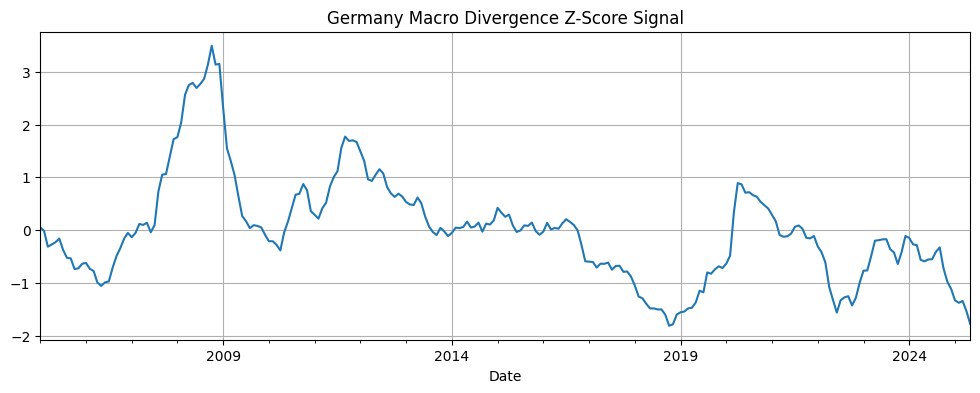

In [97]:
from scipy.stats import zscore

# Create a signal: how extreme is Germany's macro divergence
germany_signal = zscore(divergence_df["GERMANY_3M_RATE"])

# Plot signal
germany_signal.plot(figsize=(12, 4), title="Germany Macro Divergence Z-Score Signal", grid=True)


In [98]:
divergence_df.to_csv("../data/macro_divergence.csv")
#germany_signal.to_frame(name="GERMANY_MACRO_SIGNAL").to_csv("../data/signals.csv")

# Trim macro signal to match EWG asset price availability
ewg_prices = pd.read_csv(r"C:\Users\augus\macro-arb-engine\data\asset_prices.csv", index_col=0, parse_dates=True)
ewg_start = ewg_prices['EWG'].dropna().index.min()

# Trim signal to match asset price start date
germany_signal_trimmed = germany_signal[germany_signal.index >= ewg_start]

# Save only trimmed macro signal
germany_signal_trimmed.to_csv(r"C:\Users\augus\macro-arb-engine\data\signals.csv")



In [99]:
import pandas as pd

# Load macro signal (e.g. Germany Z-score)
signal = pd.read_csv(r"C:\Users\augus\macro-arb-engine\data\signals.csv", index_col=0, parse_dates=True)

# Load asset prices
prices = pd.read_csv(r"C:\Users\augus\macro-arb-engine\data\asset_prices.csv", index_col=0, parse_dates=True)

# Make both indices timezone-naive
signal.index = signal.index.tz_localize(None)
prices.index = prices.index.tz_localize(None)

# Combine and align dates
df = pd.concat([signal, prices], axis=1).dropna()
df.head()


,GERMANY_3M_RATE,SPY,EWG,FXE,EURUSD=X
Date,,,,,
2005-12-31,-0.639800,86.444450,12.656961,103.397301,1.184105
2006-01-31,-0.622704,88.520348,13.678989,106.338074,1.214845
2006-02-28,-0.733394,89.027176,13.741308,104.433922,1.193004
2006-03-31,-0.775739,90.496475,14.364499,106.374733,1.211504
2006-04-30,-0.994937,91.639595,15.062469,111.061554,1.263600


In [100]:
import pandas as pd
from statsmodels.tsa.stattools import coint

# Load your data (skip if already done)
signal = pd.read_csv(r"C:\Users\augus\macro-arb-engine\data\signals.csv", index_col=0, parse_dates=True)
prices = pd.read_csv(r"C:\Users\augus\macro-arb-engine\data\asset_prices.csv", index_col=0, parse_dates=True)

# Ensure indices are datetime and timezone-naive
signal.index = signal.index.tz_localize(None)
prices.index = prices.index.tz_localize(None)

# --- DEBUG: Print date ranges to check for overlap ---
print("Signal date range:", signal.index.min().date(), "to", signal.index.max().date())
print("EWG date range:", prices['EWG'].dropna().index.min().date(), "to", prices['EWG'].dropna().index.max().date())

# --- Trim to common date range ---
common_dates = signal.index.intersection(prices['EWG'].dropna().index)
print(f"\n✅ Found {len(common_dates)} overlapping dates")
print("Sample overlapping dates:", list(common_dates[:5]))
print("\nSample macro signal values:")
print(signal.loc[common_dates].head())

print("\nSample EWG values:")
print(prices['EWG'].loc[common_dates].head())

if len(common_dates) == 0:
    print("❌ No overlapping dates between macro signal and EWG. Cannot run cointegration test.")
else:
    # Align and join
    signal_filtered = signal.loc[common_dates]
    ewg_filtered = prices.loc[common_dates, 'EWG']
    
    joined = pd.concat([signal_filtered, ewg_filtered], axis=1).dropna()
    
    # --- Confirm column names ---
    print("Joined Data Columns:", joined.columns.tolist())

    # --- Run Cointegration Test if enough data ---
    if joined.shape[0] < 2:
        print("❌ Not enough data points to run cointegration test (need at least 2).")
    else:
        score, pvalue, _ = coint(joined['GERMANY_3M_RATE'], joined['EWG'])
        print("\n✅ Engle-Granger Cointegration Test Results:")
        print(f"Test Statistic: {score:.4f}")
        print(f"P-Value: {pvalue:.4f}")


Signal date range: 2005-01-31 to 2025-05-31
EWG date range: 2005-01-31 to 2024-12-31

✅ Found 240 overlapping dates
Sample overlapping dates: [Timestamp('2005-01-31 00:00:00'), Timestamp('2005-02-28 00:00:00'), Timestamp('2005-03-31 00:00:00'), Timestamp('2005-04-30 00:00:00'), Timestamp('2005-05-31 00:00:00')]

Sample macro signal values:
            GERMANY_3M_RATE
Date                       
2005-01-31         0.053252
2005-02-28        -0.014870
2005-03-31        -0.314967
2005-04-30        -0.274232
2005-05-31        -0.230855

Sample EWG values:
Date
2005-01-31    10.998729
2005-02-28    11.451070
2005-03-31    11.203215
2005-04-30    10.719887
2005-05-31    10.949159
Name: EWG, dtype: float64
Joined Data Columns: ['GERMANY_3M_RATE', 'EWG']

✅ Engle-Granger Cointegration Test Results:
Test Statistic: -3.1898
P-Value: 0.0716


In [103]:
import statsmodels.api as sm

if joined.shape[0] == 0:
	print("No overlapping data between macro signal and EWG. Cannot run OLS regression.")
else:
	X = joined['GERMANY_3M_RATE']
	y = joined['EWG']
	X = sm.add_constant(X)

	model = sm.OLS(y, X).fit()
	joined['spread'] = model.resid


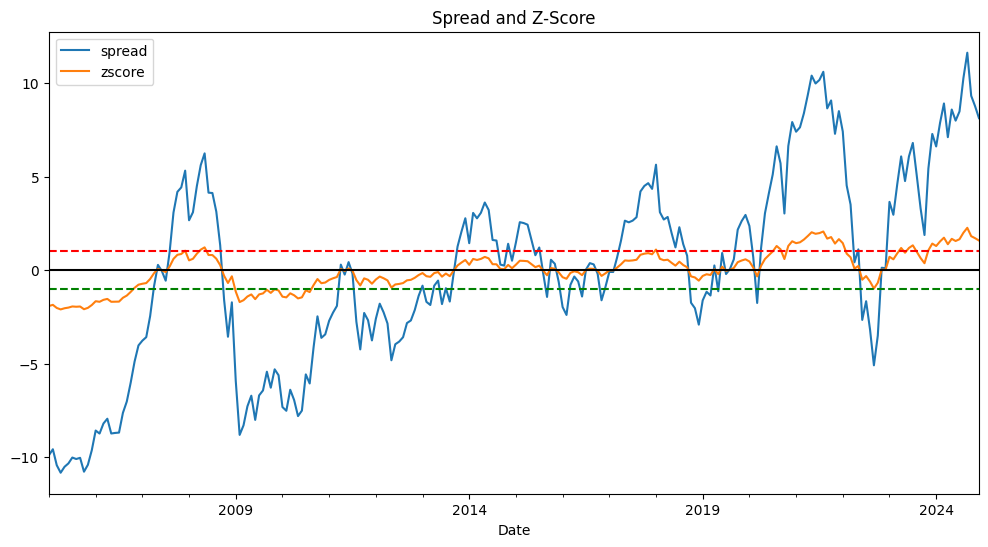

In [104]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

if 'spread' in joined.columns and joined.shape[0] > 0:
	# Ensure spread is numeric
	joined['spread'] = pd.to_numeric(joined['spread'], errors='coerce')
	# Only compute zscore if there are at least 2 non-NaN values
	if joined['spread'].count() > 1:
		joined['zscore'] = zscore(joined['spread'])
	else:
		joined['zscore'] = 0  # or np.nan, since zscore is undefined for 1 value
	joined[['spread', 'zscore']].plot(title='Spread and Z-Score', figsize=(12, 6))
	plt.axhline(1, color='red', linestyle='--')
	plt.axhline(-1, color='green', linestyle='--')
	plt.axhline(0, color='black', linestyle='-')
	plt.show()
else:
	print("No spread data available to plot.")
